In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchvision
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
from scipy.io import loadmat
from PIL import Image
import os

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [15]:
import glob
# Define the pattern to match files
path = "../Carla/datasets/scenario25_dev/unit1/mmWave_data/mmWave_power_79868*"
files = glob.glob(path)
print(files)
print(files[0][0:-4] + "_fixed.txt" == files[0])

['../Carla/datasets/scenario25_dev/unit1/mmWave_data\\mmWave_power_79868.txt', '../Carla/datasets/scenario25_dev/unit1/mmWave_data\\mmWave_power_79868_fixed.txt']
False


In [16]:
class FutureClearWindowDataset(Dataset):
    def __init__(self, csv_path, root_dir='.', window_length=16, T_f=5, transform=None):
        self.df = pd.read_csv(csv_path)
        self.root_dir = root_dir
        self.window_length = window_length
        self.T_f = T_f
        self.transform = transform
        self.resize = transforms.Resize((224, 224))  # Resize to target dimensions


        # Total number of valid sliding windows
        self.valid_indices = [
            i for i in range(len(self.df) - window_length - T_f)
        ]

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        start_idx = self.valid_indices[idx]
        end_idx = start_idx + self.window_length
        future_start = end_idx
        future_end = future_start + self.T_f

        window_df = self.df.iloc[start_idx:end_idx]
        future_df = self.df.iloc[future_start:future_end]

        # Load data for window
        lidar_frames = []
        power_frames = []
        rgb_frames = []

        for row in window_df.itertuples():
            lidar = loadmat(os.path.join(self.root_dir, row.unit1_lidar_SCR))['data']
            power = np.loadtxt(os.path.join(self.root_dir, row.unit1_pwr_60ghz)[0:-4] + "_fixed.txt")
            rgb = Image.open(os.path.join(self.root_dir, row.unit1_rgb)).convert('L')
            rgb = self.resize(rgb)
            lidar_frames.append(lidar)
            power_frames.append(power)
            rgb_frames.append(rgb)
        lidar = torch.tensor(np.stack(lidar_frames), dtype=torch.float32).permute(2, 0, 1)
        lidar[0, :, :] = lidar[0, :, :] / 16.392
        lidar[1, :, :] = (lidar[1] - (-2.0941)) / (1.5621 - (-2.0941))
        power = torch.tensor(np.stack(power_frames), dtype=torch.float32)
        rgb = torch.tensor(np.stack(rgb_frames), dtype=torch.float32)

        # Future label logic: label = 1 if no blockage in future window
        future_blockages = future_df['blockage_label'].astype(float).values
        label = 1 - int(np.all(future_blockages == 0))  # 1 = clear, 0 = blockage ahead

        label = torch.tensor(label, dtype=torch.long)


        return {
            'lidar': lidar,      # shape (window_length, ...)
            'power': power,
            'rgb': rgb,
            'label': label
        }

torch.Size([32, 2, 16, 216]) torch.Size([32, 16, 64]) torch.Size([32, 16, 224, 224]) tensor([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0])
tensor(6.2516)
tensor([[[-0.6432, -0.5312, -0.4331,  ..., -0.5284, -0.5175, -0.5698],
         [-0.6519, -0.5940, -0.4144,  ..., -0.5333, -0.5346, -0.5757],
         [-0.6526, -0.6027, -0.4110,  ..., -0.5254, -0.5183, -0.5769],
         ...,
         [-2.3822, -0.2117, -0.9971,  ..., -0.2110, -0.4272, -2.7276],
         [-1.7077, -0.5833, -0.4139,  ..., -0.4473, -0.3987, -1.1550],
         [-2.2345, -0.6815, -0.7568,  ..., -0.6951, -1.0774, -1.8399]],

        [[-0.6496, -0.5461, -0.4434,  ..., -0.5348, -0.5240, -0.5770],
         [-0.6555, -0.5351, -0.4359,  ..., -0.5302, -0.5387, -0.5777],
         [-0.6541, -0.5559, -0.4363,  ..., -0.5399, -0.5235, -0.5834],
         ...,
         [-0.6485, -0.6019, -0.4192,  ..., -0.5251, -0.5205, -0.5786],
         [-0.6515, -0.4930, -0.4289,  ..., -0.5

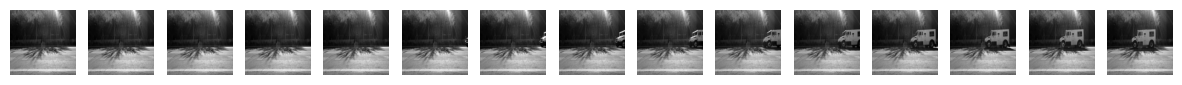

In [17]:

dataset = FutureClearWindowDataset(
    csv_path='Deepsense_dataset.csv',
    window_length=16,
    T_f=5
)

# Load from file
sample_weights_loaded = torch.load('sample_weights.pt', weights_only=True)


# Create sampler
sampler = WeightedRandomSampler(sample_weights_loaded, num_samples=len(sample_weights_loaded), replacement=True)

# Create DataLoader
loader = DataLoader(dataset, batch_size=32, sampler=sampler)


for batch in loader:
    print(batch['lidar'].shape, batch['power'].shape, batch['rgb'].shape, batch['label'])
    print(torch.max(batch['power']))
    print(batch['power'])
    
    max_value, max_index = torch.max(batch['power'], dim=1)
    
    batch_number = max_index // batch['power'].size(1)
    location_within_batch = max_index % batch['power'].size(1)
    
    print(f"The maximum value is {max_value} at batch number {batch_number} and location {location_within_batch}")
    print(batch['power'])


    #print(torch.max(batch['lidar'][:, 0, :, :]), torch.max(batch['lidar'][:, 1, :, :]), torch.min(batch['lidar'][:, 1, :, :]))
    rgb_frames = batch['rgb']  # shape: (batch_size, num_frames, channels, height, width)

    # Let's plot the first image from the first batch (index 0)
    # We'll visualize a few frames from the first example in the batch

    num_frames_to_plot = 15  # Number of frames to visualize
    fig, axes = plt.subplots(1, num_frames_to_plot, figsize=(15, 5))
    print(batch["label"][0])
    for i in range(num_frames_to_plot):
        frame = rgb_frames[0, i, :, :]  # Get the first frame, with shape (height, width)
        frame = frame.numpy()  # Convert tensor to numpy array for plotting
        axes[i].imshow(frame, cmap='gray')  # Display the image in grayscale
        axes[i].axis('off')  # Turn off axis labels
    
    plt.show()
    break

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SymmetricLiDARCNN(nn.Module):
    def __init__(self, input_channels=2, num_classes=2):
        super(SymmetricLiDARCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))  # Makes it input-size agnostic
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x


In [ ]:


class BlockagePredictionCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.01):
        super(BlockagePredictionCNN, self).__init__()

        # 3D convolution to process both temporal and spatial data
        self.conv1 = nn.Conv3d(16, 16, kernel_size=(3, 7, 7), padding=(1, 3, 3))
        self.bn1 = nn.BatchNorm3d(16)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 5, 5), padding=(1, 2, 2))
        self.bn2 = nn.BatchNorm3d(32)
        self.pool2 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(64)
        self.pool3 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        # Fusion stack
        self.fusion_conv1 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn_fusion1 = nn.BatchNorm3d(128)
        self.fusion_pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2))

        # Dropout and fully connected layers
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(128 * 4 * 7 * 7, num_classes)  # Adjusted based on the output size

    def forward(self, x):
        # x: (B, 16, 224, 224)

        x = x.unsqueeze(2)  # (B, 16, 1, 224, 224)

        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.pool3(x)

        x = self.fusion_conv1(x)
        x = F.relu(x)
        x = self.bn_fusion1(x)
        x = self.fusion_pool1(x)

        x = torch.flatten(x, 1)  # Flatten except batch dimension
        # x = self.dropout(x)  # you commented it out in your version

        print(x.shape)
        x = self.fc(x)
        return x

In [ ]:

class mmWaveSCRNet(nn.Module):
    def __init__(self, input_channels=16, num_classes=2, dropout_rate=0.2):
        super(mmWaveSCRNet, self).__init__()

        # Stack 1
        self.conv1 = nn.Conv2d(input_channels, 4, kernel_size=(1, 3), padding=(0, 1))
        self.bn1 = nn.BatchNorm2d(4)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 2))  # Reduce W: 64 → 32

        # Stack 2
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(1, 3), padding=(0, 1))
        self.bn2 = nn.BatchNorm2d(8)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 2))  # Reduce W: 32 → 16

        # Fusion Stack
        self.fusion_conv1 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn_fusion1 = nn.BatchNorm2d(16)
        self.fusion_pool1 = nn.MaxPool2d(kernel_size=(1, 2))  # W: 16 → 8

        self.fusion_conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.bn_fusion2 = nn.BatchNorm2d(16)
        self.fusion_pool2 = nn.MaxPool2d(kernel_size=(1, 2))  # W: 8 → 4

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(16 * 1 * 4, num_classes)  # Final shape (B, 16, 1, 4)

    def forward(self, x):
        x = x.unsqueeze(2)  # (B, 16, 1, 64)

        x = F.relu(self.bn1(self.conv1(x)))  # (B, 4, 1, 64)
        x = self.pool1(x)                    # (B, 4, 1, 32)

        x = F.relu(self.bn2(self.conv2(x)))  # (B, 8, 1, 32)
        x = self.pool2(x)                    # (B, 8, 1, 16)

        x = F.relu(self.bn_fusion1(self.fusion_conv1(x)))  # (B, 16, 1, 16)
        x = self.fusion_pool1(x)                           # (B, 16, 1, 8)

        x = F.relu(self.bn_fusion2(self.fusion_conv2(x)))  # (B, 16, 1, 8)
        x = self.fusion_pool2(x)                           # (B, 16, 1, 4)

        x = torch.flatten(x, 1)                            # (B, 16*1*4)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [ ]:

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_lidar = mmWaveSCRNet(input_channels=16, num_classes=2).to(device)

# Loss and optimizer
class_weights = {0: 1.0932087765216907, 1: 6.728603435399553}
weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_weights))], dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lidar.parameters(), lr=1e-4)

# Lists to store loss and accuracy
loss_history = []
acc_history = []

# Training
model_lidar.train()
for epoch in range(10):
    running_loss = 0.0
    total = 0
    correct = 0
    
    for _, inputs in zip(range(10), loader):
        labels = inputs["label"].to(device)
        inputs = inputs["power"].to(device)
        
        optimizer.zero_grad()
        outputs = model_lidar(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(labels, predicted)
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)
    print(epoch_acc)
    
# Plotting
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(loss_history, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(acc_history, marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()
